<a href="https://colab.research.google.com/github/Zoro1092000/Do_an_tot_nghiep/blob/main/In_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Pip and Import

In [1]:
import os
import os.path as osp
import torch
import sys

os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric==1.4.3
!pip install torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install deepdish==0.3.5

import torch.nn as nn
from torch.nn import Parameter
from torch_geometric.utils import scatter_
from torch_geometric.nn.inits import glorot, zeros
from torch_scatter import scatter_add
from torch.utils.data import DataLoader, Dataset


from itertools import chain
import pickle
import h5py
import deepdish as dd
import numpy as np
from tqdm import tqdm
import inspect
import time
import math
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 2. Data

In [2]:
# Data utils
def h5group_to_dict(h5group):
    group_dict = {k: v[()] for k, v in chain(h5group.items(), h5group.attrs.items())}
    return group_dict

def sub_dict(full_dict, *keys, to_tensor):
    return {k: torch.tensor(full_dict[k]) if to_tensor else full_dict[k] for k in keys if k in full_dict}

def build_graph_from_dict_pyg(graph_dict, to_tensor=True):
    from torch_geometric.data import Data

    g = Data(**sub_dict(graph_dict, 'edge_index', 'x', 'y', 'edge_attr', 'edge_y', to_tensor=to_tensor))
    return g

# Data loader
class GraphDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=128, shuffle=False, num_workers=0):

        def collate_graph(graph_obj_list):
            from torch_geometric.data import Batch
            batch = Batch.from_data_list(graph_obj_list)
            return batch

        super().__init__(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            collate_fn=collate_graph,
            num_workers=num_workers)

# BotnetDataset
class BotnetDataset(Dataset):

    def __init__(self, name='chord', root='data/botnet', split='train', graph_format='pyg', split_idx=None, add_nfeat_ones=True,
                 in_memory=True):
        super().__init__()
        assert name in ['chord', 'debru', 'kadem', 'leet', 'c2', 'p2p']
        assert split in ['train', 'val', 'test']

        if isinstance(root, str):
            root = osp.expanduser(osp.normpath(root))

        self.name = name
        self.root = root
        self.split = split
        self.split_idx = split_idx
        self.add_nfeat_ones = add_nfeat_ones

        self._graph_format = graph_format
        if split == 'train':
            self.path = self.processed_paths[0]
            self.num_graphs = 768
        elif split == 'val':
            self.path = self.processed_paths[1]
            self.num_graphs = 96
        elif split == 'test':
            self.path = self.processed_paths[2]
            self.num_graphs = 96

        # in_memory = False
        # self.data = h5py.File(self.path, 'r')
        self.data = None    # defer opening file in each process to make multiprocessing work
        self.data_type = 'file'
            
    @property
    def processed_dir(self):
        return osp.join(self.root, 'processed')

    @property
    def processed_file_names(self):
        return [self.name + '_' + s + '.hdf5' for s in ('train', 'val', 'test')]

    @property
    def processed_paths(self):
        return [osp.join(self.processed_dir, f) for f in self.processed_file_names]

    def __len__(self):
        return self.num_graphs

    def __getitem__(self, index):
        if self.data_type == 'dict':
            graph_dict = self.data[str(index)]
        elif self.data_type == 'file':
            if self.data is None:
                # only open once in each process
                self.data = h5py.File(self.path, 'r')
            graph_dict = h5group_to_dict(self.data[str(index)])
        else:
            raise ValueError

        # graph_format == 'pyg':
        return build_graph_from_dict_pyg(graph_dict)


    def __iter__(self):
        for i in range(self.num_graphs):
            yield self[i]

    def __repr__(self):
        return f'{self.__class__.__name__}(topology: {self.name} | split: {self.split} | ' \
               f'#graphs: {len(self)} | graph format: {self.graph_format})'

# 3. Measure Performance.

In [3]:
def f1(target, pred, label):
    # F1 = 2 * (precision * recall) / (precision + recall)
    tp = np.sum((target==label) & (pred==label))
    fp = np.sum((target!=label) & (pred==label))
    fn = np.sum((pred!=label) & (target==label))
    
    if tp+fp==0 or tp+fn==0:
      return np.nan

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    if precision+recall==0:
      return np.nan
      
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def f1_macro(pred, target):
    return np.mean([f1(target, pred, label) for label in range(0, 2)])


def accuracy(pred, target):
    return (pred == target).sum().item() / len(target)


def true_positive(pred, target):
    return (target[pred == 1] == 1).sum().item()


def false_positive(pred, target):
    return (target[pred == 1] == 0).sum().item()


def true_negative(pred, target):
    return (target[pred == 0] == 0).sum().item()


def false_negative(pred, target):
    return (target[pred == 0] == 1).sum().item()


def recall(pred, target):
    try:
        return true_positive(pred, target) / (target == 1).sum().item()
    except:  # divide by zero
        return -1


def precision(pred, target):
    try:
        prec = true_positive(pred, target) / (pred == 1).sum().item()
        return prec
    except:  # divide by zero
        return -1


def f1_score(pred, target):
    prec = precision(pred, target)
    rec = recall(pred, target)
    try:
        return 2 * (prec * rec) / (prec + rec)
    except:
        return 0


def false_positive_rate(pred, target):
    try:
        return false_positive(pred, target) / (target == 0).sum().item()
    except:  # divide by zero
        return -1


def false_negative_rate(pred, target):
    try:
        return false_negative(pred, target) / (target == 1).sum().item()
    except:  # divide by zero
        return -1

In [4]:
list_fn = []

In [5]:
def eval_metrics(target, pred_prob, threshold=0.5):
    if isinstance(target, torch.Tensor):
        target = target.cpu().numpy()
    if isinstance(pred_prob, torch.Tensor):
        pred_prob = pred_prob.cpu().numpy()

    pred = (pred_prob >= threshold).astype(int)

    for i in range(target.shape[0]):
      if target[i] == 1 and pred[i] == 0:
        list_fn.append(i)

    acc = accuracy(pred, target)
    fpr = false_positive_rate(pred, target)
    fnr = false_negative_rate(pred, target)
    rec = recall(pred, target)
    prc = precision(pred, target)
    f1 = f1_score(pred, target)
    f1macro = f1_macro(pred, target)
    result_dict = {'acc': acc, 'fpr': fpr, 'fnr': fnr, 'rec': rec, 'prc': prc, 'f1': f1, 'f1_macro': f1macro}

    return result_dict


def dict_value_add(dict1, dict2):
    result = {key: dict1.get(key, 0) + dict2.get(key, 0)
              for key in set(dict1) | set(dict2)}
    return result


def dict_value_div(dict, n):
    result = {key: value / n for key, value in dict.items()}
    return result


def eval_predictor(dataset, predictor):
    result_dict_avg = {}
    loss_avg = 0

    step = 0
    for data in dataset:
        # prediction
        try:
            pred_prob, loss = predictor(data)
            loss_avg += loss
        except ValueError:  # if "too many values to unpack"
            pred_prob = predictor(data)

        # get the ground truth target
        # graph_format == 'pyg':
        target = data.y

        # compute the evaluation metrics
        result_dict = eval_metrics(target, pred_prob)

        result_dict_avg = dict_value_add(result_dict_avg, result_dict)
        # step = step + 1
        # if step == 10:
        #   break
        #break

    # average the metrics across all graphs in the dataset as final results
    result_dict_avg = dict_value_div(result_dict_avg, len(dataset))
    loss_avg = loss_avg / len(dataset)  

    return result_dict_avg, loss_avg

class PygModelPredictor:
    def __init__(self, model, loss_fcn=torch.nn.CrossEntropyLoss()):
        self.model = model
        self.loss_fcn = loss_fcn
        self.device = next(model.parameters()).device

    def __call__(self, data):
        self.model.eval()
        data = data.to(self.device)
        with torch.no_grad():
            # custom the below line to adjust to your model's input format for forward pass
            out = self.model(data.x, data.edge_index)
            loss = self.loss_fcn(out, data.y.long())
            pred_prob = torch.softmax(out, dim=1)[:, 1]
        return pred_prob, loss.float()

# 4. Model

In [6]:
import torch.nn as nn

class GINModel(nn.Module):
    def __init__(self, dim_input_feature, dim_hidden_feature, num_layers, num_classes, non_linear='relu', dropout=0.0):
        super().__init__()

        self.dim_input_feature = dim_input_feature
        self.dim_hidden_feature = dim_hidden_feature

        self.num_layers = num_layers
        self.num_classes = num_classes
        
        from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
        from torch_geometric.nn import GINConv
        
        self.gin_net = nn.ModuleList()
        for i in range(self.num_layers):
          if i == 0:
            self.gin_net.append(
                GINConv(
                  Sequential(Linear(self.dim_input_feature, self.dim_hidden_feature),
                             BatchNorm1d(self.dim_hidden_feature), ReLU(),
                             Linear(self.dim_hidden_feature, self.dim_hidden_feature), ReLU()), train_eps = True))
          else:
            self.gin_net.append(
                GINConv(
                  Sequential(Linear(self.dim_hidden_feature, self.dim_hidden_feature),
                             BatchNorm1d(self.dim_hidden_feature), ReLU(),
                             Linear(self.dim_hidden_feature, self.dim_hidden_feature), ReLU()), train_eps = True)) 

        self.dropout = nn.Dropout(dropout)

        self.residuals = nn.ModuleList()
        for i in range(self.num_layers):
          if i == 0:
            self.residuals.append(nn.Linear(self.dim_input_feature, self.dim_hidden_feature, bias=True))
          else:
            self.residuals.append(nn.Identity())

        self.num_residuals = len(self.residuals)

        self.non_linear = activation(non_linear)

        # self.final_type == 'proj':
        self.final = nn.Linear(self.dim_hidden_feature, num_classes)

    def reset_parameters(self):
        for net in self.gin_net:
            net.reset_parameters()
        # self.residual_hop = 1
        for net in self.residuals:
            net.reset_parameters()
        # self.final_type != 'none':
        self.final.reset_parameters()

    def forward(self, x, edge_index):
        xr = None
        add_xr_at = -1

        for n, net in enumerate(self.gin_net):
            # pass to a GIN layer with non-linear activation
            xo = net(x, edge_index)
            xo = self.dropout(xo)
            # deal with residual connections
            # self.residual_hop = 1
            if n < self.num_residuals:
                xr = self.residuals[n](x)
                add_xr_at = n
            if n == add_xr_at:
                xo = self.non_linear(xo + xr)

            x = xo
        # size of x: (B * N, dim_hidden_feature) -> (B * N, num_classes)
        x = self.final(x)

        return x

# 5. Load data

In [7]:
data_dir = '/content/drive/Shareddrives/botnetdata/P2P'
data_name = 'p2p' # 'chord', 'debru', 'kadem', 'leet', 'c2', 'p2p'

# ========== load the dataset
print('loading dataset...')

test_ds = BotnetDataset(name=data_name, root=data_dir, split='test',
                        in_memory=True, graph_format='pyg')


loading dataset...


# 7. Test

In [8]:
GIN = torch.load("/content/saved_models/GIN_25_ 0.9951412038904616.pt")
#print(GIN)

In [9]:
predictorGIN = PygModelPredictor(GIN)

In [10]:
result_dict_avg_GIN, loss_avg_GIN = eval_predictor(test_ds, predictorGIN)
print(f'Testing --- loss: {loss_avg_GIN:.5f}')
print(' ' * 10 + ', '.join(['{}: {:.5f}'.format(k, v) for k, v in result_dict_avg_GIN.items()]))

Testing --- loss: 0.00128
          fnr: 0.00376, f1_macro: 0.99764, acc: 0.99981, f1: 0.99538, rec: 0.99624, fpr: 0.00011, prc: 0.99504


In [11]:
print(list_fn)

[4548, 142562, 142619, 142686, 140950, 141197, 141241, 141487, 2306, 141796, 142294, 261, 141943, 141982, 141996, 142570, 4064, 144198, 144317, 141923, 17375, 47694, 107902, 120998, 142144, 142295, 29266, 141924, 27740, 140632, 56653, 142592, 142635, 142691, 142844, 142926, 142936, 143065, 140967, 141601, 19633, 136448, 136651, 136767, 3788, 17912, 140835, 17302, 144355, 144356, 141914, 142134, 142283, 141246, 141318, 141410, 579, 842, 2044, 5880, 6883, 7878, 12298, 144463, 144476, 144643, 144649, 144761, 145220, 145307, 141954, 141955, 142024, 142075, 142146, 142153, 142272, 144735, 142263, 142281, 142461, 142909, 138308, 138396, 19228, 138634, 145244, 985, 3824, 5245, 8564, 121122, 144441, 144590, 144717, 144889, 144986, 145179, 144900, 144947, 142837, 6286, 140705, 140721, 140806, 140955, 145481, 113476, 140086, 141999, 142049, 142064, 141489, 141570, 141658, 141795, 141982, 145138, 145182, 145359, 48836, 143391, 143435, 143733, 65, 142117, 142167, 142237, 142294, 141900, 135063, 14

In [12]:
dict_fn = {}

In [13]:
first_graph = test_ds['0']

In [14]:
print(first_graph)

Data(edge_index=[2, 1617376], edge_y=[1617376], x=[143891, 1], y=[143891])


In [15]:
edge_index = first_graph.edge_index

In [16]:
node_label = first_graph.y

In [17]:
print(edge_index)

tensor([[     0,      0,      0,  ..., 143888, 143889, 143890],
        [     0,      8,   1469,  ..., 143888, 143889, 143890]])


In [18]:
list_fn = list_fn[1:]

In [19]:
print(list_fn)

[142562, 142619, 142686, 140950, 141197, 141241, 141487, 2306, 141796, 142294, 261, 141943, 141982, 141996, 142570, 4064, 144198, 144317, 141923, 17375, 47694, 107902, 120998, 142144, 142295, 29266, 141924, 27740, 140632, 56653, 142592, 142635, 142691, 142844, 142926, 142936, 143065, 140967, 141601, 19633, 136448, 136651, 136767, 3788, 17912, 140835, 17302, 144355, 144356, 141914, 142134, 142283, 141246, 141318, 141410, 579, 842, 2044, 5880, 6883, 7878, 12298, 144463, 144476, 144643, 144649, 144761, 145220, 145307, 141954, 141955, 142024, 142075, 142146, 142153, 142272, 144735, 142263, 142281, 142461, 142909, 138308, 138396, 19228, 138634, 145244, 985, 3824, 5245, 8564, 121122, 144441, 144590, 144717, 144889, 144986, 145179, 144900, 144947, 142837, 6286, 140705, 140721, 140806, 140955, 145481, 113476, 140086, 141999, 142049, 142064, 141489, 141570, 141658, 141795, 141982, 145138, 145182, 145359, 48836, 143391, 143435, 143733, 65, 142117, 142167, 142237, 142294, 141900, 135063, 142693, 

In [20]:
cnt = 0
for index in list_fn:
  print("node = ")
  print(cnt)
  cnt = cnt + 1
  list_tmp = []

  pos = list(edge_index[0]).index(index)

  for i in range(pos, edge_index.shape[1]):
    #print(i)
    if (edge_index[0][i] != index):
      break
    list_tmp.append(int(edge_index[1][i]))
    # if edge_index[0][i] == index:
    #   list_tmp.append(edge_index[1][i])
    # elif edge_index[1][i] == index:
    #   list_tmp.append(edge_index[0][i])

  dict_fn[index] = list_tmp
  if cnt == 1:
    break

node = 
0


In [21]:
print(dict_fn)

{142562: [2, 9, 22, 33, 49, 50, 51, 57, 61, 77, 84, 106, 108, 120, 128, 131, 140, 157, 167, 170, 172, 174, 175, 176, 178, 186, 192, 198, 200, 208, 213, 215, 222, 248, 252, 262, 264, 273, 291, 303, 309, 315, 323, 327, 338, 344, 346, 347, 356, 383, 393, 394, 395, 397, 400, 402, 411, 415, 427, 428, 448, 475, 486, 493, 494, 517, 520, 524, 533, 545, 546, 553, 560, 566, 574, 582, 583, 584, 592, 599, 609, 610, 611, 623, 631, 633, 657, 659, 668, 682, 686, 700, 708, 719, 723, 726, 745, 749, 752, 809, 810, 835, 852, 864, 871, 878, 886, 905, 907, 936, 964, 996, 997, 1001, 1002, 1008, 1009, 1017, 1026, 1029, 1041, 1044, 1056, 1065, 1086, 1092, 1103, 1108, 1113, 1114, 1123, 1124, 1129, 1136, 1147, 1159, 1166, 1236, 1241, 1260, 1269, 1321, 1360, 1375, 1393, 1425, 1443, 1452, 1454, 1463, 1471, 1478, 1529, 1551, 1574, 1575, 1576, 1580, 1615, 1630, 1678, 1694, 1710, 1712, 1735, 1742, 1774, 1783, 1817, 1819, 1832, 1841, 1852, 1853, 1890, 1894, 1900, 1921, 1932, 1938, 1961, 1962, 1975, 1979, 2029, 2055, 

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

In [23]:
list_adj = dict_fn.get(142562)

In [24]:
print(list_adj)

[2, 9, 22, 33, 49, 50, 51, 57, 61, 77, 84, 106, 108, 120, 128, 131, 140, 157, 167, 170, 172, 174, 175, 176, 178, 186, 192, 198, 200, 208, 213, 215, 222, 248, 252, 262, 264, 273, 291, 303, 309, 315, 323, 327, 338, 344, 346, 347, 356, 383, 393, 394, 395, 397, 400, 402, 411, 415, 427, 428, 448, 475, 486, 493, 494, 517, 520, 524, 533, 545, 546, 553, 560, 566, 574, 582, 583, 584, 592, 599, 609, 610, 611, 623, 631, 633, 657, 659, 668, 682, 686, 700, 708, 719, 723, 726, 745, 749, 752, 809, 810, 835, 852, 864, 871, 878, 886, 905, 907, 936, 964, 996, 997, 1001, 1002, 1008, 1009, 1017, 1026, 1029, 1041, 1044, 1056, 1065, 1086, 1092, 1103, 1108, 1113, 1114, 1123, 1124, 1129, 1136, 1147, 1159, 1166, 1236, 1241, 1260, 1269, 1321, 1360, 1375, 1393, 1425, 1443, 1452, 1454, 1463, 1471, 1478, 1529, 1551, 1574, 1575, 1576, 1580, 1615, 1630, 1678, 1694, 1710, 1712, 1735, 1742, 1774, 1783, 1817, 1819, 1832, 1841, 1852, 1853, 1890, 1894, 1900, 1921, 1932, 1938, 1961, 1962, 1975, 1979, 2029, 2055, 2077, 213

In [25]:
print(len(list_adj))

1734


In [26]:
g = nx.DiGraph()

In [36]:
list_adj = list_adj[:1734]

In [37]:
color = ["red"]

In [29]:
# for i in range(node_label.shape[0]):
#   if node_label[i] == 0:
#     print("----------")
#     print(node_label[i])
#     print(i)


In [38]:
for i in list_adj:
  g.add_edge(142562, i)
  if int(node_label[i]) == 1:
    color.append("red")
  else:
    color.append("blue")

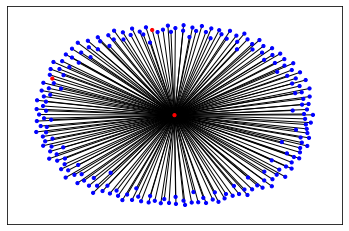

In [43]:
nx.draw_networkx(g, node_color = color, with_labels=False, arrows=False, node_size=10)